In [ ]:
# Install used packages if needed
!pip install opencv-python
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install tensorflow

In [9]:
import time
start_time = time.time()

In [ ]:
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
base_path = Path.cwd()
cell_types = ["im_Dyskeratotic", "im_Koilocytotic", "im_Metaplastic", "im_Parabasal", "im_Superficial-Intermediate"]

images = []
labels = []

In [12]:
%%capture
for cell_type in cell_types:
    folder_path = os.path.join(base_path, cell_type, "CROPPED")
    
    for img_name in os.listdir(folder_path):
        if img_name.endswith((".bmp")):
            img_path = os.path.join(folder_path, img_name)
            
            img = cv2.imread(img_path)
            
            img = cv2.resize(img, (128, 128))
            img = img / 255.0
            
            images.append(img)
            labels.append(cell_type)

In [13]:
images = np.array(images)
labels = np.array(labels)

label_map = {cell_type: idx for idx, cell_type in enumerate(cell_types)}
encoded_labels = np.array([label_map[label] for label in labels])
one_hot_labels = to_categorical(encoded_labels)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(images, one_hot_labels, test_size=0.2, random_state=0)

X_train = X_train.reshape(-1, 128, 128, 3)
X_test = X_test.reshape(-1, 128, 128, 3)

X_train = X_train / 255.0
X_test = X_test / 255.0

In [15]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(len(cell_types), activation="softmax"))

model.compile(optimizer=Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 24s 212ms/step - accuracy: 0.2485 - loss: 1.5883 - val_accuracy: 0.3667 - val_loss: 1.3989
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - accuracy: 0.3812 - loss: 1.3327 - val_accuracy: 0.3864 - val_loss: 1.4061
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 205ms/step - accuracy: 0.4114 - loss: 1.2748 - val_accuracy: 0.4815 - val_loss: 1.2296
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - accuracy: 0.4307 - loss: 1.2455 - val_accuracy: 0.4741 - val_loss: 1.1992
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 205ms/step - accuracy: 0.4683 - loss: 1.1983 - val_accuracy: 0.4864 - val_loss: 1.1991
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - accuracy: 0.4932 - loss: 1.1603 - val_accuracy: 0.4951 - val_loss: 1.1583
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.4950 - loss: 1.1643 - val_accuracy: 0.5136 - val_loss: 1.1291
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 204ms/step - accuracy: 0.5210 - loss: 1

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

In [18]:
precision = precision_score(true_classes, predicted_classes, average="weighted")
recall = recall_score(true_classes, predicted_classes, average="weighted")
f1 = f1_score(true_classes, predicted_classes, average="weighted")

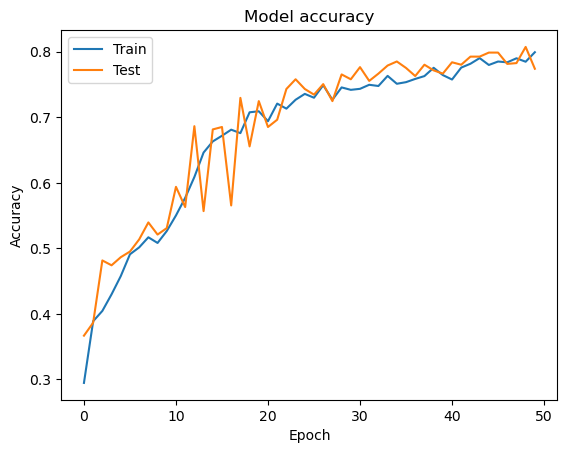

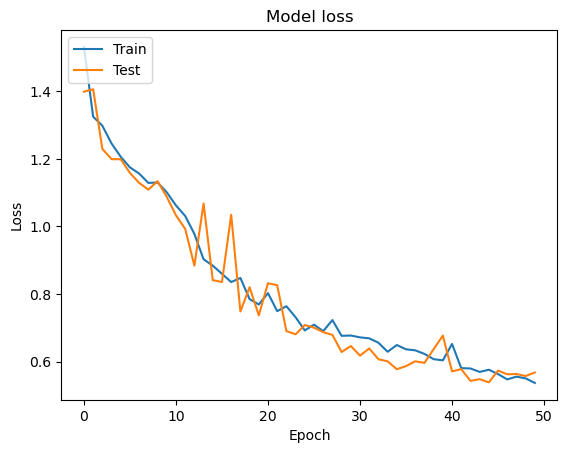

In [19]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

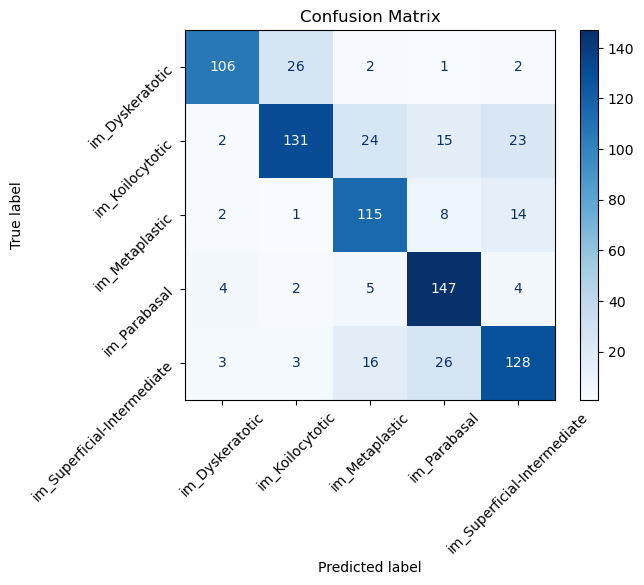

In [20]:
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cell_types)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title("Confusion Matrix")
plt.show()

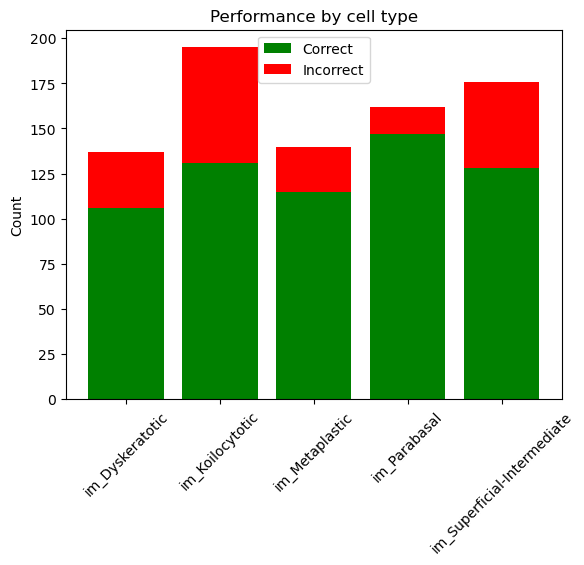

In [21]:
correct_per_class = np.zeros(len(cell_types))
incorrect_per_class = np.zeros(len(cell_types))

for i in range(len(cell_types)):
    correct_per_class[i] = np.sum((true_classes == i) & (predicted_classes == i))
    incorrect_per_class[i] = np.sum((true_classes == i) & (predicted_classes != i))

x = np.arange(len(cell_types))
plt.bar(x, correct_per_class, color="green", label="Correct")
plt.bar(x, incorrect_per_class, bottom=correct_per_class, color="red", label="Incorrect")
plt.xticks(x, cell_types, rotation=45)
plt.ylabel("Count")
plt.title("Performance by cell type")
plt.legend()
plt.show()

In [22]:
true_labels = y_test
predicted_probs = predictions

fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(cell_types)):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

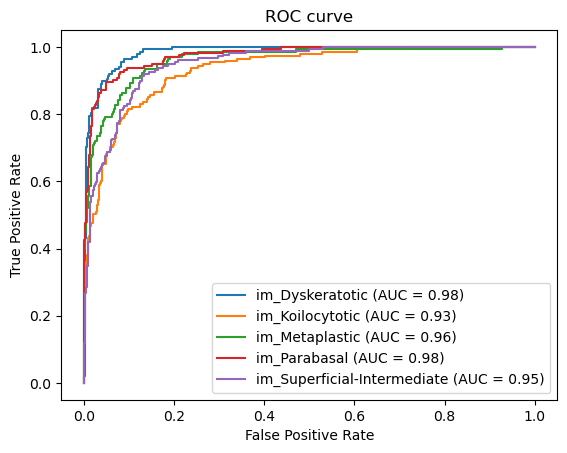

In [23]:
for i in range(len(cell_types)):
    plt.plot(fpr[i], tpr[i], label=f"{cell_types[i]} (AUC = {roc_auc[i]:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")

plt.show()

In [24]:
end_time = time.time()
total_time = end_time - start_time

In [25]:
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss*100:.4f}")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")
print(f"Computation Time: {total_time:.2f}s")

Test Accuracy: 77.41%
Test Loss: 56.80%
Precision: 78.13%
Recall: 77.41%
F1 Score: 77.31%
Computation Time: 1246.63s
